<a href="https://colab.research.google.com/github/arazm21/ML-homework_4/blob/main/expression_notebook_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# loading the data and organising it

In [1]:
! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge

Mounted at /content/drive
 96% 273M/285M [00:00<00:00, 582MB/s]
100% 285M/285M [00:04<00:00, 74.7MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [2]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 44.2 MB/s eta 0:00:00


In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import numpy as np
from PIL import Image
from torchvision import transforms

# ─── 1) Augmentations for minority classes ────────────────────────────────────

aug_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),  # finally convert to tensor in [0,1]
])

# ─── 2) Base “no‐transform” behavior ─────────────────────────────────────────

class ExpressionDatasetFromDF(Dataset):
    def __init__(self, dataframe):
        # Expect columns exactly ["emotion", "pixels", "Usage"]
        # Each “pixels” entry is a string of “230  19  …”
        self.images = dataframe[" pixels"].apply(
            lambda x: np.fromstring(x, sep=" ", dtype=np.uint8).reshape(48, 48)
        )
        # Stack into a (N, 1, 48, 48) float32 tensor in [0,1]
        self.images = torch.tensor(
            np.stack(self.images.values), dtype=torch.float32
        ).unsqueeze(1) / 255.0
        self.labels = torch.tensor(dataframe["emotion"].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


# ─── 3) Oversampling / augmentation wrapper ──────────────────────────────────

class AugmentedExpressionDataset(Dataset):
    def __init__(self, base_dataset, targets, num_aug_per_sample=1):
        """
        base_dataset: an ExpressionDatasetFromDF (no transforms applied)
        targets: list of ints (same length as base_dataset)
        """
        self.base_dataset = base_dataset
        self.targets = targets
        self.class_counts = Counter(targets)
        self.max_count = max(self.class_counts.values())

        # Build a list of “base indices” to duplicate + augment
        self.augmented_indices = []
        for cls_label, count in self.class_counts.items():
            n_to_add = self.max_count - count
            if n_to_add <= 0:
                continue
            # pick with replacement from all indices whose target == cls_label
            indices_of_cls = [
                i for i, t in enumerate(targets) if t == cls_label
            ]
            sampled = random.choices(indices_of_cls, k=n_to_add * num_aug_per_sample)
            self.augmented_indices.extend(sampled)

        print(f"‣ Base dataset size: {len(self.base_dataset)}")
        print(f"‣ Augmenting {len(self.augmented_indices)} extra samples to balance classes.")
        print(f"‣ Resulting dataset size: {len(self.base_dataset) + len(self.augmented_indices)}")

    def __len__(self):
        return len(self.base_dataset) + len(self.augmented_indices)

    def __getitem__(self, idx):
        if idx < len(self.base_dataset):
            # no augmentation for the “original” sample
            img_tensor, label = self.base_dataset[idx]
            return img_tensor, label
        else:
            # for augmented ones: take the base index, convert back to PIL, augment, then ToTensor
            base_idx = self.augmented_indices[idx - len(self.base_dataset)]
            img_tensor, label = self.base_dataset[base_idx]
            # img_tensor is (1,48,48) float in [0,1]. Convert back to uint8 PIL:
            arr_uint8 = (img_tensor.squeeze().numpy() * 255).astype(np.uint8)
            pil_img = Image.fromarray(arr_uint8, mode="L")
            img_aug = aug_transform(pil_img)  # now a (1,48,48) FloatTensor in [0,1]
            return img_aug, label


# ─── 4) Revised get_data (no more “slice”) ───────────────────────────────────

def get_data(csv_file="icml_face_data.csv", train=True):
    """
    - Reads icml_face_data.csv (which has exactly ["emotion","pixels","Usage"]).
    - Splits by Usage == "Training" vs. "PublicTest".
    - For train: wraps in AugmentedExpressionDataset. For test/val: returns raw dataset.
    """
    full_df = pd.read_csv(csv_file)

    if train:
        df_part = full_df[full_df[" Usage"] == "Training"].reset_index(drop=True)
    else:
        df_part = full_df[full_df[" Usage"] == "PublicTest"].reset_index(drop=True)

    print(f"‣ Loaded '{'Training' if train else 'PublicTest'}' => {len(df_part)} samples before augmentation/slicing.")

    base_ds = ExpressionDatasetFromDF(df_part)

    if train:
        targets = df_part["emotion"].tolist()
        balanced_ds = AugmentedExpressionDataset(base_ds, targets)
        return balanced_ds
    else:
        return base_ds


def make_loader(dataset, batch_size):
    return DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=1,
    )


In [17]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import numpy as np
from PIL import Image
from torchvision import transforms

# ─── 1) Augmentations for minority classes ────────────────────────────────────

aug_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),  # finally convert to tensor in [0,1]
])

# ─── 2) Base “no‐transform” behavior ─────────────────────────────────────────

class ExpressionDatasetFromDF(Dataset):
    def __init__(self, dataframe):
        # Expect columns exactly ["emotion", "pixels", "Usage"]
        # Each “pixels” entry is a string of “230  19  …”
        self.images = dataframe[" pixels"].apply(
            lambda x: np.fromstring(x, sep=" ", dtype=np.uint8).reshape(48, 48)
        )
        # Stack into a (N, 1, 48, 48) float32 tensor in [0,1]
        self.images = torch.tensor(
            np.stack(self.images.values), dtype=torch.float32
        ).unsqueeze(1) / 255.0
        self.labels = torch.tensor(dataframe["emotion"].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


# ─── 3) Oversampling / augmentation wrapper ──────────────────────────────────

class AugmentedExpressionDataset(Dataset):
    def __init__(self, base_dataset, targets, num_aug_per_sample=1):
        """
        base_dataset: an ExpressionDatasetFromDF (no transforms applied)
        targets: list of ints (same length as base_dataset)
        """
        self.base_dataset = base_dataset
        self.targets = targets
        self.class_counts = Counter(targets)
        self.max_count = max(self.class_counts.values())

        # Build a list of “base indices” to duplicate + augment
        self.augmented_indices = []
        for cls_label, count in self.class_counts.items():
            n_to_add = self.max_count - count
            if n_to_add <= 0:
                continue
            # pick with replacement from all indices whose target == cls_label
            indices_of_cls = [
                i for i, t in enumerate(targets) if t == cls_label
            ]
            sampled = random.choices(indices_of_cls, k=n_to_add * num_aug_per_sample)
            self.augmented_indices.extend(sampled)

        print(f"‣ Base dataset size: {len(self.base_dataset)}")
        print(f"‣ Augmenting {len(self.augmented_indices)} extra samples to balance classes.")
        print(f"‣ Resulting dataset size: {len(self.base_dataset) + len(self.augmented_indices)}")

    def __len__(self):
        return len(self.base_dataset) + len(self.augmented_indices)

    def __getitem__(self, idx):
        if idx < len(self.base_dataset):
            # no augmentation for the “original” sample
            img_tensor, label = self.base_dataset[idx]
            return img_tensor, label
        else:
            # for augmented ones: take the base index, convert back to PIL, augment, then ToTensor
            base_idx = self.augmented_indices[idx - len(self.base_dataset)]
            img_tensor, label = self.base_dataset[base_idx]
            # img_tensor is (1,48,48) float in [0,1]. Convert back to uint8 PIL:
            arr_uint8 = (img_tensor.squeeze().numpy() * 255).astype(np.uint8)
            pil_img = Image.fromarray(arr_uint8, mode="L")
            img_aug = aug_transform(pil_img)  # now a (1,48,48) FloatTensor in [0,1]
            return img_aug, label


# ─── 4) Revised get_data (no more “slice”) ───────────────────────────────────

def get_data(csv_file="icml_face_data.csv", train=True):
    """
    - Reads icml_face_data.csv (which has exactly ["emotion","pixels","Usage"]).
    - Splits by Usage == "Training" vs. "PublicTest".
    - For train: wraps in AugmentedExpressionDataset. For test/val: returns raw dataset.
    """
    full_df = pd.read_csv(csv_file)

    if train:
        df_part = full_df[full_df[" Usage"] == "Training"].reset_index(drop=True)
    else:
        df_part = full_df[full_df[" Usage"] == "PublicTest"].reset_index(drop=True)

    print(f"‣ Loaded '{'Training' if train else 'PublicTest'}' => {len(df_part)} samples before augmentation/slicing.")

    base_ds = ExpressionDatasetFromDF(df_part)

    if train:
        targets = df_part["emotion"].tolist()
        balanced_ds = AugmentedExpressionDataset(base_ds, targets)
        return balanced_ds
    else:
        return base_ds


def make_loader(dataset, batch_size):
    return DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=2,
    )


# ─── 5) Quick sanity check ───────────────────────────────────────────────────

if __name__ == "__main__":
    # 1) Inspect base “Training” size (should be ~28,709 for FER2013).
    train_ds = get_data(csv_file="icml_face_data.csv", train=True)
    print(f"Len of train_ds (after augmentation): {len(train_ds)}\n")

    # 2) Inspect base “PublicTest” size (should be ~3,589).
    val_ds = get_data(csv_file="icml_face_data.csv", train=False)
    print(f"Len of val_ds (no augmentation): {len(val_ds)}\n")

    # 3) Create DataLoader and confirm iteration count
    train_loader = make_loader(train_ds, batch_size=64)
    total_seen = sum(len(batch[0]) for batch in train_loader)
    print(f"Total images seen via train_loader: {total_seen}")


‣ Loaded 'Training' => 28709 samples before augmentation/slicing.
‣ Base dataset size: 28709
‣ Augmenting 21796 extra samples to balance classes.
‣ Resulting dataset size: 50505
Len of train_ds (after augmentation): 50505

‣ Loaded 'PublicTest' => 3589 samples before augmentation/slicing.
Len of val_ds (no augmentation): 3589

Total images seen via train_loader: 50505


## test that loading was ok

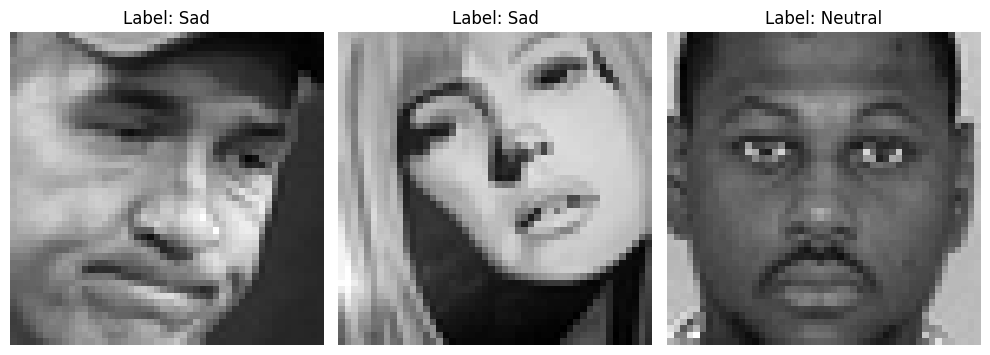

In [6]:
# Load and create loader
dataset = get_data(train=False)
loader = make_loader(dataset, batch_size=3)

# Get a batch
images, labels = next(iter(loader))

# Class names from FER2013
emotion_names = [
    "Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"
]

# Plot the first 3 images
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {emotion_names[labels[i].item()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# connecting WANDB

In [7]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [8]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arazm21 (arazm21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# different attempted architectures

## baseline model

In [73]:
class BaselineModel(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 1)
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
      self.pooling = nn.MaxPool2d(2,2)
      self.relu = nn.ReLU()

      self.flatten = nn.Flatten()
      self.linear = nn.Linear((128 * 6 * 6), 128)
      self.output = nn.Linear(128, 7)


    def forward(self, x):
      x = self.conv1(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

## enhanced baseline model

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class EnhancedBaselineModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 48 -> 24

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 24 -> 12

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 12 -> 6

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 6 -> 3
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


## ImprovedModel

In [67]:
import torch.nn as nn

class ImprovedModel(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        # — conv backbone with 4 pooling stages —
        self.conv1    = nn.Conv2d(1,   32, 3, padding=1, bias=False)
        self.bn1      = nn.BatchNorm2d(32)
        self.conv2    = nn.Conv2d(32,  64, 3, padding=1, bias=False)
        self.bn2      = nn.BatchNorm2d(64)
        self.conv3    = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn3      = nn.BatchNorm2d(128)
        self.conv4    = nn.Conv2d(128,256, 3, padding=1, bias=False)
        self.bn4      = nn.BatchNorm2d(256)

        self.pool     = nn.MaxPool2d(2,2)
        self.relu     = nn.ReLU(inplace=True)
        self.drop_conv= nn.Dropout2d(dropout_p)

        # # — two extra conv layers (no further pooling) —
        # self.conv5    = nn.Conv2d(256, 512, 3, padding=1, bias=False)
        # self.bn5      = nn.BatchNorm2d(512)
        # self.conv6    = nn.Conv2d(512, 512, 3, padding=1, bias=False)
        # self.bn6      = nn.BatchNorm2d(512)

        # — richer head with 4 FCs —
        self.flatten  = nn.Flatten()
        # Corrected input size for the first linear layer
        self.fc1      = nn.Linear(256 * 3 * 3, 512, bias=False) # 256 channels * 3x3 spatial size
        self.bn_fc1   = nn.BatchNorm1d(512)
        self.drop1    = nn.Dropout(dropout_p)
        self.fc2      = nn.Linear(512, 256, bias=False)
        self.bn_fc2   = nn.BatchNorm1d(256)
        self.drop2    = nn.Dropout(dropout_p)
        self.fc3      = nn.Linear(256, 128, bias=False)
        self.bn_fc3   = nn.BatchNorm1d(128)
        self.drop3    = nn.Dropout(dropout_p)
        self.fc4      = nn.Linear(128, 64, bias=False)
        self.bn_fc4   = nn.BatchNorm1d(64)
        self.drop4    = nn.Dropout(dropout_p)
        self.output   = nn.Linear(64, 7)

    def forward(self, x):
        # conv blocks 1–4 with pooling
        for conv, bn in [(self.conv1,self.bn1),
                         (self.conv2,self.bn2),
                         (self.conv3,self.bn3),
                         (self.conv4,self.bn4)]:
            x = conv(x)
            x = bn(x)
            x = self.relu(x)
            x = self.pool(x)
            x = self.drop_conv(x)

        # # extra conv blocks 5–6 (no more pooling)
        # x = self.conv5(x)
        # x = self.bn5(x)
        # x = self.relu(x)
        # x = self.drop_conv(x)

        # x = self.conv6(x)
        # x = self.bn6(x)
        # x = self.relu(x)
        # x = self.drop_conv(x)

        # FC head
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.drop1(x)

        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = self.relu(x)
        x = self.drop2(x)

        x = self.fc3(x)
        x = self.bn_fc3(x)
        x = self.relu(x)
        x = self.drop3(x)

        x = self.fc4(x)
        x = self.bn_fc4(x)
        x = self.relu(x)
        x = self.drop4(x)

        x = self.output(x)
        return x

## convnet

In [9]:
# import torch.nn as nn

# class ConvNet_super_simple(nn.Module):
#     def __init__(self, kernels, classes=7):
#         super(ConvNet_super_simple, self).__init__()

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         # Assuming 48x48 input, after two 2x2 poolings -> 48/2/2 = 12x12
#         self.fc = nn.Linear(12 * 12 * kernels[1], classes)

#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out
import torch
import torch.nn as nn

class ConvNet_Improved(nn.Module):
    def __init__(self, kernels, classes=7):
        super(ConvNet_Improved, self).__init__()

        # First conv block
        self.conv1 = nn.Conv2d(1, kernels[0], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(kernels[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second conv block
        self.conv2 = nn.Conv2d(kernels[0], kernels[1], kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(kernels[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third conv block
        self.conv3 = nn.Conv2d(kernels[1], kernels[2], kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(kernels[2])
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Assuming 48x48 input → 3 poolings: 48 → 24 → 12 → 6
        self.flattened_dim = 6 * 6 * kernels[2]
        self.fc = nn.Linear(self.flattened_dim, classes)

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


## resnet

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, dropout_rate=0.2):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        self.dropout = nn.Dropout2d(dropout_rate)

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # out = self.dropout(out)  # ✅ Dropout after residual addition
        out += identity
        out = F.relu(out)

        return out

class SimpleResNet15(nn.Module):
    def __init__(self, in_channels=1, num_classes=7, dropout_rate=0.13):
        super(SimpleResNet15, self).__init__()

        self.entry = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layers = nn.Sequential(
          ResidualBlock(32, 64, downsample=True, dropout_rate=dropout_rate),
          ResidualBlock(64, 128, downsample=True, dropout_rate=dropout_rate),
          ResidualBlock(128, 256, downsample=True, dropout_rate=dropout_rate),
          ResidualBlock(256, 512, downsample=True, dropout_rate=dropout_rate),
          ResidualBlock(512, 1024, downsample=True, dropout_rate=dropout_rate),
          ResidualBlock(1024, 2048, downsample=True, dropout_rate=dropout_rate),
          ResidualBlock(2048, 2048, downsample=True, dropout_rate=dropout_rate),
          ResidualBlock(2048, 2048, downsample=True, dropout_rate=dropout_rate),

          ResidualBlock(2048, 1024, downsample=True, dropout_rate=dropout_rate),
          ResidualBlock(1024, 512, downsample=True, dropout_rate=dropout_rate),
          ResidualBlock(512, 256, downsample=True, dropout_rate=dropout_rate),

          ResidualBlock(256, 256, downsample=False, dropout_rate=dropout_rate),
          ResidualBlock(256, 256, downsample=False, dropout_rate=dropout_rate)
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 256)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.entry(x)
        x = self.layers(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


## googlenet(mini)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class MiniInception(nn.Module):
#     def __init__(self, in_ch, c1, c3red, c3, pool_proj):
#         super().__init__()
#         # 1×1 branch
#         self.b1 = nn.Conv2d(in_ch, c1, kernel_size=1)
#         # 1×1 → 3×3 branch
#         self.b2_1 = nn.Conv2d(in_ch, c3red, kernel_size=1)
#         self.b2_2 = nn.Conv2d(c3red, c3,   kernel_size=3, padding=1)
#         # pool → 1×1 branch
#         self.b3_pool = nn.MaxPool2d(3, stride=1, padding=1)
#         self.b3_proj = nn.Conv2d(in_ch, pool_proj, kernel_size=1)
#         self.bn = nn.BatchNorm2d(c1 + c3 + pool_proj)

#     def forward(self, x):
#         b1 = self.b1(x)
#         b2 = self.b2_2(F.relu(self.b2_1(x)))
#         b3 = self.b3_proj(self.b3_pool(x))
#         out = torch.cat([b1, b2, b3], dim=1)
#         return F.relu(self.bn(out))


# class MiniGoogLeNet(nn.Module):
#     def __init__(self, num_classes=7, aux_on=True):
#         super().__init__()
#         self.aux_on = aux_on

#         # ---- stem ----
#         self.stem = nn.Sequential(
#             nn.Conv2d(1, 32, 3, padding=1),
#             nn.BatchNorm2d(32), nn.ReLU(),
#             nn.MaxPool2d(2, 2)  # 48→24
#         )

#         # ---- two Inception blocks ----
#         self.inc1 = MiniInception(32, c1=16, c3red=16, c3=24, pool_proj=16)  # outputs 56
#         self.inc2 = MiniInception(56, c1=32, c3red=24, c3=32, pool_proj=24)  # outputs 88

#         # auxiliary head (after inc1)
#         if aux_on:
#             self.aux = nn.Sequential(
#                 nn.AdaptiveAvgPool2d((4,4)),
#                 nn.Conv2d(56, 32, 1), nn.ReLU(),
#                 nn.Flatten(),
#                 nn.Linear(32*4*4, 128), nn.ReLU(), nn.Dropout(0.5),
#                 nn.Linear(128, num_classes)
#             )

#         # ---- classifier head ----
#         self.pool = nn.AdaptiveAvgPool2d((1,1))
#         self.fc   = nn.Sequential(
#             nn.Flatten(),
#             nn.Dropout(0.5),
#             nn.Linear(88, num_classes)
#         )

#     def forward(self, x):
#         x = self.stem(x)            # → [B,32,24,24]
#         x1 = self.inc1(x)           # → [B,56,24,24]

#         # you can still compute aux_out if you want,
#         # but we won't return it so training code stays unchanged
#         if self.training and self.aux_on:
#             _ = self.aux(x1)

#         x2 = F.max_pool2d(x1, 2, 2) # → [B,56,12,12]
#         x2 = self.inc2(x2)          # → [B,88,12,12]

#         x3 = self.pool(x2)          # → [B,88,1,1]
#         main_out = self.fc(x3)      # → [B,num_classes]

#         return main_out
class MiniInception(nn.Module):
    def __init__(self, in_ch, c1, c3red, c3, pool_proj, dropout=0.2):
        super().__init__()
        # 1×1 branch
        self.b1 = nn.Conv2d(in_ch, c1, 1)
        # 1×1 → 3×3 branch
        self.b2_1 = nn.Conv2d(in_ch, c3red, 1)
        self.b2_2 = nn.Conv2d(c3red, c3, 3, padding=1)
        # pool → 1×1 branch
        self.b3_pool = nn.MaxPool2d(3, stride=1, padding=1)
        self.b3_proj = nn.Conv2d(in_ch, pool_proj, 1)

        self.bn = nn.BatchNorm2d(c1 + c3 + pool_proj)
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x):
        b1 = self.b1(x)
        b2 = self.b2_2(F.relu(self.b2_1(x)))
        b3 = self.b3_proj(self.b3_pool(x))
        out = torch.cat([b1, b2, b3], dim=1)
        out = F.relu(self.bn(out))
        return self.dropout(out)


class ComplexMiniGoogLeNet(nn.Module):
    def __init__(self, num_classes=7, aux_on=True):
        super().__init__()
        self.aux_on = aux_on

        # ── Stem ──
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 48 → 24
        )

        # ── Inception Blocks ──
        self.inc1 = MiniInception(32, c1=16, c3red=16, c3=32, pool_proj=16, dropout=0.2)   # →64 ch
        self.inc2 = MiniInception(64, c1=24, c3red=24, c3=48, pool_proj=24, dropout=0.2)   # →96 ch
        self.inc3 = MiniInception(96, c1=32, c3red=32, c3=64, pool_proj=32, dropout=0.3)   # →128 ch

        # ── Auxiliary head (computed but not returned) ──
        if aux_on:
            self.aux = nn.Sequential(
                nn.AdaptiveAvgPool2d((4, 4)),
                nn.Conv2d(96, 48, 1), nn.ReLU(),
                nn.Flatten(),
                nn.Linear(48 * 4 * 4, 256), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(256, num_classes)
            )

        # ── Final classifier ──
        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)          # → [B,32,24,24]
        x1 = self.inc1(x)         # → [B,64,24,24]
        x2 = self.inc2(x1)        # → [B,96,24,24]

        # compute aux but ignore its output
        if self.training and self.aux_on:
            _ = self.aux(x2)

        x3 = F.max_pool2d(x2, 2, 2)  # → [B,96,12,12]
        x3 = self.inc3(x3)           # → [B,128,12,12]

        x4 = self.final_pool(x3)     # → [B,128,1,1]
        main_out = self.classifier(x4)
        return main_out

## densenet

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        return torch.cat([x, out], dim=1)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super().__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(DenseLayer(in_channels, growth_rate))
            in_channels += growth_rate
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        return self.pool(x)

class MiniDenseNet(nn.Module):
    def __init__(self, growth_rate=12, num_classes=7):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2 * growth_rate, kernel_size=3, padding=1, bias=False)
        num_channels = 2 * growth_rate

        self.block1 = DenseBlock(num_channels, growth_rate, num_layers=4)
        num_channels += 4 * growth_rate
        self.trans1 = TransitionLayer(num_channels, num_channels // 2)
        num_channels = num_channels // 2

        self.block2 = DenseBlock(num_channels, growth_rate, num_layers=4)
        num_channels += 4 * growth_rate
        self.trans2 = TransitionLayer(num_channels, num_channels // 2)
        num_channels = num_channels // 2

        self.bn = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(self.block1(x))
        x = self.trans2(self.block2(x))
        x = self.relu(self.bn(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


## vision transformer

In [ ]:
import torch
from torch import nn
from einops.layers.torch import Rearrange
from einops import repeat
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=8, emb_size=128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class ExpressionViT(nn.Module):
    def __init__(self, num_classes=7, aux_on=True, img_size=48, patch_size=8,
                 emb_dim=128, n_layers=6, dropout=0.1, heads=4):
        super().__init__()
        self.aux_on = aux_on
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=1,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)

        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads=heads, dropout=dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout=dropout)))
            )
            self.layers.append(transformer_block)

        # Auxiliary head (after layer n_layers//2, similar to your original design)
        if aux_on:
            self.aux_head = nn.Sequential(
                nn.LayerNorm(emb_dim),
                nn.Linear(emb_dim, emb_dim // 2),
                nn.GELU(),
                nn.Dropout(0.5),
                nn.Linear(emb_dim // 2, num_classes)
            )

        # Main classification head
        self.head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Dropout(0.5),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

            # Auxiliary output (after middle layer)
            if i == self.n_layers // 2 and self.training and self.aux_on:
                aux_cls_token = x[:, 0, :]  # Extract cls token
                _ = self.aux_head(aux_cls_token)  # Compute but don't return

        # Main output based on classification token
        main_out = self.head(x[:, 0, :])
        return main_out


class CompactExpressionViT(nn.Module):
    def __init__(self, num_classes=7, aux_on=True):
        super().__init__()
        self.aux_on = aux_on

        # Compact configuration for faster training
        img_size = 48
        patch_size = 6
        emb_dim = 96
        n_layers = 4
        heads = 3
        dropout = 0.2

        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=1,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)

        # Learnable params
        num_patches = (img_size // patch_size) ** 2  # 16 patches
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads=heads, dropout=dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim * 2, dropout=dropout)))
            )
            self.layers.append(transformer_block)

        # Auxiliary head
        if aux_on:
            self.aux_head = nn.Sequential(
                nn.LayerNorm(emb_dim),
                nn.Linear(emb_dim, emb_dim // 2),
                nn.GELU(),
                nn.Dropout(0.3),
                nn.Linear(emb_dim // 2, num_classes)
            )

        # Main classification head
        self.head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Dropout(0.3),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

            # Auxiliary output (after 2nd layer for compact model)
            if i == 1 and self.training and self.aux_on:
                aux_cls_token = x[:, 0, :]
                _ = self.aux_head(aux_cls_token)

        # Main output based on classification token
        main_out = self.head(x[:, 0, :])
        return main_out

from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 1, patch_size = 8, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=1, img_size=48, patch_size=4, emb_dim=64,
                n_layers=12, out_dim=7, dropout=0.2, heads=8):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])



In [ ]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable=True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    inputs = Input(shape=cf["input_shape"])
    patches = Patches(cf["patch_size"])(inputs)
    x = PatchEncoder(num_patches=cf["num_patches"], projection_dim=cf["projection_dim"])(patches)
    cls_token = ClassToken()(x)
    x = Concatenate(axis=1)([cls_token, x])

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    x = LayerNormalization()(x)
    x = x[:, 0]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model

# geting everything ready

In [10]:
def make(config):
    # Make the data
    train_dataset = get_data(train=True)
    test_dataset = get_data(train=False)
    train_loader = make_loader(train_dataset, batch_size=config.batch_size)
    test_loader = make_loader(test_dataset, batch_size=config.batch_size)

    # Make the model
    model = ComplexMiniGoogLeNet().to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    return model, train_loader, test_loader, criterion, optimizer

In [11]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

## early stop training

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def validate(model, val_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total
    return val_loss, val_acc

def train(model, train_loader, val_loader, criterion, optimizer, config):
    wandb.watch(model, criterion, log="all", log_freq=10)

    early_stopper = EarlyStopping(patience=15, min_delta=0.001)

    example_ct = 0
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        model.train()
        running_correct = 0
        running_total = 0

        for _, (images, labels) in enumerate(train_loader):
            loss, batch_correct, batch_total = train_batch(images, labels, model, optimizer, criterion)
            example_ct += len(images)
            batch_ct += 1

            running_correct += batch_correct
            running_total += batch_total

            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)
                print(f"batch number: {batch_ct + 1}")

        train_acc = running_correct / running_total

        # ⏱️ Validate at the end of the epoch
        val_loss, val_acc = validate(model, val_loader, criterion)
        wandb.log({
            "epoch": epoch,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "train_accuracy": train_acc
        })
        print(f"Epoch {epoch + 1}: val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}, train_acc = {train_acc:.4f}")

        # Check early stopping
        early_stopper(val_loss)
        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)

    return loss, correct, total

## normal training

In [12]:
import torch
from tqdm import tqdm
import wandb
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np


def train(model, train_loader, val_loader, criterion, optimizer, config, class_names= ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]):
    # wandb.init(
    #     project="",
    #     config={
    #         "epochs": config.epochs,
    #         "batch_size": train_loader.batch_size,
    #         "optimizer": optimizer.__class__.__name__,
    #         "lr": optimizer.param_groups[0]["lr"],
    #         "criterion": criterion.__class__.__name__,
    #     }
    # )
    # wandb.watch(model, log="all", log_freq=100)
    model.to(config.device)

    train_loss_plot, val_loss_plot = [], []
    train_acc_plot, val_acc_plot = [], []

    for epoch in range(config.epochs):
        # Training
        model.train()
        total_train_loss, train_correct, train_total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1} [Train]"):
            images, labels = images.to(config.device), labels.to(config.device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = total_train_loss / train_total
        train_acc = train_correct / train_total

        # Validation
        val_loss, val_acc, all_targets, all_preds = validate(model, val_loader, criterion, config.device)

        # F1 and Confusion Matrix
        cm = confusion_matrix(all_targets, all_preds)
        f1_per_class = f1_score(all_targets, all_preds, average=None)

        log_data = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
        }
        for i, name in enumerate(class_names):
            log_data[f"f1_{name}"] = f1_per_class[i]
        wandb.log(log_data)

        # Confusion matrix image
        fig, ax = plt.subplots(figsize=(6,6))
        im = ax.imshow(cm, cmap="Blues")
        fig.colorbar(im, ax=ax)
        ax.set_xticks(np.arange(len(class_names)))
        ax.set_yticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha="right")
        ax.set_yticklabels(class_names)
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                ax.text(j, i, cm[i, j], ha="center", va="center")
        ax.set_title(f"Confusion Matrix - Epoch {epoch+1}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        wandb.log({"confusion_matrix": wandb.Image(fig)})
        plt.close(fig)

        # Store for final plots
        train_loss_plot.append(train_loss)
        val_loss_plot.append(val_loss)
        train_acc_plot.append(train_acc)
        val_acc_plot.append(val_acc)

        print(f"Epoch {epoch+1}/{config.epochs}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Final loss/accuracy curves
    epochs_range = list(range(1, config.epochs + 1))

    fig1, ax1 = plt.subplots()
    ax1.plot(epochs_range, train_loss_plot, label="Train Loss")
    ax1.plot(epochs_range, val_loss_plot, label="Val Loss")
    ax1.set_title("Loss vs Epoch")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    wandb.log({"loss_curve": wandb.Image(fig1)})
    plt.close(fig1)

    fig2, ax2 = plt.subplots()
    ax2.plot(epochs_range, train_acc_plot, label="Train Accuracy")
    ax2.plot(epochs_range, val_acc_plot, label="Val Accuracy")
    ax2.set_title("Accuracy vs Epoch")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    wandb.log({"accuracy_curve": wandb.Image(fig2)})
    plt.close(fig2)

    return model

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / total
    val_acc = correct / total
    return avg_val_loss, val_acc, all_targets, all_preds

import torch
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wandb

def test(model, test_loader, device, class_names=None):
    model.eval()
    correct, total = 0, 0
    all_preds, all_targets = [], []
    misclassified_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

            # Save misclassified images
            mis_mask = (predicted != labels)
            mis_imgs = images[mis_mask]
            mis_lbls = labels[mis_mask]
            mis_preds = predicted[mis_mask]
            for img, true_lbl, pred_lbl in zip(mis_imgs, mis_lbls, mis_preds):
                misclassified_images.append((img.cpu(), true_lbl.item(), pred_lbl.item()))

    acc = correct / total
    f1_macro = f1_score(all_targets, all_preds, average="macro")
    f1_per_class = f1_score(all_targets, all_preds, average=None)

    print(f"\nTest Accuracy: {acc:.2%}")
    print(f"F1 Macro: {f1_macro:.4f}")
    print("\nClassification Report:\n", classification_report(all_targets, all_preds, target_names=class_names))

    # Log numeric metrics
    log_data = {
        "test_accuracy": acc,
        "test_f1_macro": f1_macro,
    }
    if class_names:
        for i, name in enumerate(class_names):
            log_data[f"f1_{name}"] = f1_per_class[i]
    wandb.log(log_data)

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=class_names if class_names else "auto",
        yticklabels=class_names if class_names else "auto",
        cmap="Blues"
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix (Test)")
    # wandb.log({
    #     "confusion_matrix_final": wandb.Image(fig),
    #     "confusion_matrix_raw": wandb.Table(data=cm.tolist(), columns=class_names, rows=class_names),
    # })
    plt.close(fig)

    wandb.log({
    "confusion_matrix_final": wandb.Image(fig),
    "confusion_matrix_raw": wandb.plot.confusion_matrix(
        probs=None,
        y_true=all_targets,
        preds=all_preds,
        class_names=class_names if class_names else None
    )
})
    # Log a few misclassified images
    if class_names:
        wrong_table = wandb.Table(columns=["Image", "True Label", "Predicted Label"])
        for img, true_lbl, pred_lbl in misclassified_images[:25]:
            img_np = img.squeeze().numpy()  # assumes grayscale
            wrong_table.add_data(
                wandb.Image(img_np, caption=f"Pred: {class_names[pred_lbl]}, GT: {class_names[true_lbl]}"),
                class_names[true_lbl],
                class_names[pred_lbl]
            )
        wandb.log({"misclassified_samples": wrong_table})

    # Export ONNX
    dummy_input = torch.randn(1, *images.shape[1:]).to(device)
    torch.onnx.export(model, dummy_input, "model.onnx")
    wandb.save("model.onnx")

    # Optionally log model architecture as a string
    model_arch_str = str(model)
    wandb.log({"model_architecture": wandb.Html(f"<pre>{model_arch_str}</pre>")})


## pipeline

In [13]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="expression_dataset_final",
                    config=hyperparameters,
                    name = "ComplexMiniGoogLeNet"):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      # and use them to train the model
      # train(model, train_loader, criterion, optimizer, config)

      # # and test its final performance
      # test(model, test_loader)
      train(model, train_loader, test_loader, criterion, optimizer, config)
      test(model, test_loader, config.device)  # final test; you can use actual test set here if available

    wandb.finish()
    return model

In [22]:
config = dict(
    epochs=50,
    classes=7,
    #kernels=[32, 64, 128],
    batch_size=256,
    learning_rate=6e-4,
    dataset="Facial Expression Recognition",
    architecture="ComplexMiniGoogLeNet_longer",
    device = device)

‣ Loaded 'Training' => 28709 samples before augmentation/slicing.
‣ Base dataset size: 28709
‣ Augmenting 21796 extra samples to balance classes.
‣ Resulting dataset size: 50505
‣ Loaded 'PublicTest' => 3589 samples before augmentation/slicing.
Label distribution in augmented training data:
Class 0: 7215 samples
Class 1: 7215 samples
Class 2: 7215 samples
Class 3: 7215 samples
Class 4: 7215 samples
Class 5: 7215 samples
Class 6: 7215 samples


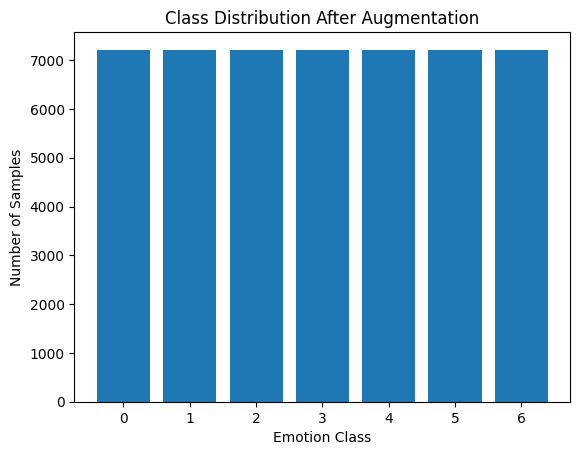

Total images seen via train_loader: 50505


In [19]:
total = 0
train_dataset = get_data(train=True)
test_dataset = get_data(train=False)
train_loader = make_loader(train_dataset, batch_size=config['batch_size'])
test_loader = make_loader(test_dataset, batch_size=config['batch_size'])
for batch in train_loader:
    images, labels = batch
    total += len(images)
# Count class occurrences
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.tolist())

label_counts = Counter(all_labels)

# Print counts
print("Label distribution in augmented training data:")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} samples")

# Optional: plot for visual confirmation
plt.bar(label_counts.keys(), label_counts.values(), tick_label=[str(i) for i in label_counts.keys()])
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution After Augmentation')
plt.show()
print(f"Total images seen via train_loader: {total}")

# train!

In [23]:
model = model_pipeline(config)

‣ Loaded 'Training' => 28709 samples before augmentation/slicing.
‣ Base dataset size: 28709
‣ Augmenting 21796 extra samples to balance classes.
‣ Resulting dataset size: 50505
‣ Loaded 'PublicTest' => 3589 samples before augmentation/slicing.
ComplexMiniGoogLeNet(
  (stem): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (inc1): MiniInception(
    (b1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (b2_1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (b2_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b3_pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (b3_proj): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

Epoch 1 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.06it/s]


Epoch 1/50: Train Loss=1.8966, Train Acc=0.2091 | Val Loss=1.8009, Val Acc=0.2538


Epoch 2 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.22it/s]


Epoch 2/50: Train Loss=1.7951, Train Acc=0.2661 | Val Loss=1.7765, Val Acc=0.2538


Epoch 3 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.02it/s]


Epoch 3/50: Train Loss=1.7337, Train Acc=0.3058 | Val Loss=1.7193, Val Acc=0.2895


Epoch 4 [Train]: 100%|██████████| 198/198 [00:16<00:00, 11.94it/s]


Epoch 4/50: Train Loss=1.6753, Train Acc=0.3368 | Val Loss=1.6472, Val Acc=0.3305


Epoch 5 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.34it/s]


Epoch 5/50: Train Loss=1.6443, Train Acc=0.3527 | Val Loss=1.6426, Val Acc=0.3154


Epoch 6 [Train]: 100%|██████████| 198/198 [00:17<00:00, 11.27it/s]


Epoch 6/50: Train Loss=1.6215, Train Acc=0.3629 | Val Loss=1.6165, Val Acc=0.3480


Epoch 7 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.53it/s]


Epoch 7/50: Train Loss=1.6042, Train Acc=0.3715 | Val Loss=1.6354, Val Acc=0.3293


Epoch 8 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.42it/s]


Epoch 8/50: Train Loss=1.5807, Train Acc=0.3841 | Val Loss=1.5507, Val Acc=0.3686


Epoch 9 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.32it/s]


Epoch 9/50: Train Loss=1.5683, Train Acc=0.3929 | Val Loss=1.5403, Val Acc=0.3842


Epoch 10 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.47it/s]


Epoch 10/50: Train Loss=1.5454, Train Acc=0.4022 | Val Loss=1.5200, Val Acc=0.3918


Epoch 11 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.34it/s]


Epoch 11/50: Train Loss=1.5335, Train Acc=0.4098 | Val Loss=1.5017, Val Acc=0.4040


Epoch 12 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.29it/s]


Epoch 12/50: Train Loss=1.5218, Train Acc=0.4114 | Val Loss=1.4660, Val Acc=0.4310


Epoch 13 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.24it/s]


Epoch 13/50: Train Loss=1.5113, Train Acc=0.4174 | Val Loss=1.4676, Val Acc=0.4302


Epoch 14 [Train]: 100%|██████████| 198/198 [00:17<00:00, 11.61it/s]


Epoch 14/50: Train Loss=1.4998, Train Acc=0.4221 | Val Loss=1.4488, Val Acc=0.4363


Epoch 15 [Train]: 100%|██████████| 198/198 [00:17<00:00, 11.44it/s]


Epoch 15/50: Train Loss=1.4904, Train Acc=0.4263 | Val Loss=1.4380, Val Acc=0.4441


Epoch 16 [Train]: 100%|██████████| 198/198 [00:17<00:00, 11.51it/s]


Epoch 16/50: Train Loss=1.4788, Train Acc=0.4294 | Val Loss=1.4164, Val Acc=0.4570


Epoch 17 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.09it/s]


Epoch 17/50: Train Loss=1.4754, Train Acc=0.4313 | Val Loss=1.4327, Val Acc=0.4355


Epoch 18 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.23it/s]


Epoch 18/50: Train Loss=1.4640, Train Acc=0.4365 | Val Loss=1.4065, Val Acc=0.4617


Epoch 19 [Train]: 100%|██████████| 198/198 [00:16<00:00, 11.93it/s]


Epoch 19/50: Train Loss=1.4565, Train Acc=0.4399 | Val Loss=1.4537, Val Acc=0.4372


Epoch 20 [Train]: 100%|██████████| 198/198 [00:17<00:00, 11.64it/s]


Epoch 20/50: Train Loss=1.4488, Train Acc=0.4442 | Val Loss=1.3900, Val Acc=0.4745


Epoch 21 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.22it/s]


Epoch 21/50: Train Loss=1.4353, Train Acc=0.4480 | Val Loss=1.4472, Val Acc=0.4402


Epoch 22 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.31it/s]


Epoch 22/50: Train Loss=1.4336, Train Acc=0.4510 | Val Loss=1.3716, Val Acc=0.4773


Epoch 23 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.35it/s]


Epoch 23/50: Train Loss=1.4283, Train Acc=0.4535 | Val Loss=1.3737, Val Acc=0.4739


Epoch 24 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.10it/s]


Epoch 24/50: Train Loss=1.4218, Train Acc=0.4546 | Val Loss=1.3554, Val Acc=0.4862


Epoch 25 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.22it/s]


Epoch 25/50: Train Loss=1.4127, Train Acc=0.4563 | Val Loss=1.3464, Val Acc=0.4960


Epoch 26 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.20it/s]


Epoch 26/50: Train Loss=1.4036, Train Acc=0.4600 | Val Loss=1.3444, Val Acc=0.4868


Epoch 27 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.27it/s]


Epoch 27/50: Train Loss=1.4075, Train Acc=0.4598 | Val Loss=1.3465, Val Acc=0.4840


Epoch 28 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.16it/s]


Epoch 28/50: Train Loss=1.3983, Train Acc=0.4631 | Val Loss=1.3443, Val Acc=0.4870


Epoch 29 [Train]: 100%|██████████| 198/198 [00:16<00:00, 11.85it/s]


Epoch 29/50: Train Loss=1.3965, Train Acc=0.4662 | Val Loss=1.3438, Val Acc=0.4898


Epoch 30 [Train]: 100%|██████████| 198/198 [00:16<00:00, 11.99it/s]


Epoch 30/50: Train Loss=1.3879, Train Acc=0.4652 | Val Loss=1.3370, Val Acc=0.4937


Epoch 31 [Train]: 100%|██████████| 198/198 [00:16<00:00, 11.69it/s]


Epoch 31/50: Train Loss=1.3900, Train Acc=0.4650 | Val Loss=1.3270, Val Acc=0.4971


Epoch 32 [Train]: 100%|██████████| 198/198 [00:16<00:00, 11.68it/s]


Epoch 32/50: Train Loss=1.3835, Train Acc=0.4686 | Val Loss=1.3527, Val Acc=0.4751


Epoch 33 [Train]: 100%|██████████| 198/198 [00:16<00:00, 11.67it/s]


Epoch 33/50: Train Loss=1.3766, Train Acc=0.4700 | Val Loss=1.3304, Val Acc=0.4915


Epoch 34 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.42it/s]


Epoch 34/50: Train Loss=1.3722, Train Acc=0.4724 | Val Loss=1.3228, Val Acc=0.5007


Epoch 35 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.49it/s]


Epoch 35/50: Train Loss=1.3708, Train Acc=0.4727 | Val Loss=1.3006, Val Acc=0.5052


Epoch 36 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.41it/s]


Epoch 36/50: Train Loss=1.3678, Train Acc=0.4732 | Val Loss=1.3252, Val Acc=0.4904


Epoch 37 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.47it/s]


Epoch 37/50: Train Loss=1.3628, Train Acc=0.4780 | Val Loss=1.3123, Val Acc=0.4957


Epoch 38 [Train]: 100%|██████████| 198/198 [00:16<00:00, 11.84it/s]


Epoch 38/50: Train Loss=1.3579, Train Acc=0.4782 | Val Loss=1.3046, Val Acc=0.4976


Epoch 39 [Train]: 100%|██████████| 198/198 [00:16<00:00, 11.95it/s]


Epoch 39/50: Train Loss=1.3574, Train Acc=0.4789 | Val Loss=1.3033, Val Acc=0.5029


Epoch 40 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.17it/s]


Epoch 40/50: Train Loss=1.3507, Train Acc=0.4808 | Val Loss=1.3134, Val Acc=0.4935


Epoch 41 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.18it/s]


Epoch 41/50: Train Loss=1.3528, Train Acc=0.4801 | Val Loss=1.3170, Val Acc=0.4979


Epoch 42 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.40it/s]


Epoch 42/50: Train Loss=1.3449, Train Acc=0.4818 | Val Loss=1.2966, Val Acc=0.5007


Epoch 43 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.49it/s]


Epoch 43/50: Train Loss=1.3469, Train Acc=0.4817 | Val Loss=1.2941, Val Acc=0.4985


Epoch 44 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.49it/s]


Epoch 44/50: Train Loss=1.3448, Train Acc=0.4847 | Val Loss=1.2891, Val Acc=0.5127


Epoch 45 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.42it/s]


Epoch 45/50: Train Loss=1.3397, Train Acc=0.4835 | Val Loss=1.3129, Val Acc=0.5043


Epoch 46 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.46it/s]


Epoch 46/50: Train Loss=1.3355, Train Acc=0.4849 | Val Loss=1.2812, Val Acc=0.5102


Epoch 47 [Train]: 100%|██████████| 198/198 [00:17<00:00, 11.09it/s]


Epoch 47/50: Train Loss=1.3358, Train Acc=0.4840 | Val Loss=1.2882, Val Acc=0.5026


Epoch 48 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.16it/s]


Epoch 48/50: Train Loss=1.3380, Train Acc=0.4868 | Val Loss=1.2854, Val Acc=0.5141


Epoch 49 [Train]: 100%|██████████| 198/198 [00:16<00:00, 12.11it/s]


Epoch 49/50: Train Loss=1.3287, Train Acc=0.4886 | Val Loss=1.2793, Val Acc=0.5060


Epoch 50 [Train]: 100%|██████████| 198/198 [00:15<00:00, 12.61it/s]


Epoch 50/50: Train Loss=1.3308, Train Acc=0.4862 | Val Loss=1.2747, Val Acc=0.4982

Test Accuracy: 49.82%
F1 Macro: 0.4278

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.11      0.17       467
           1       0.53      0.29      0.37        56
           2       0.27      0.10      0.15       496
           3       0.58      0.85      0.69       895
           4       0.36      0.52      0.43       653
           5       0.76      0.64      0.70       415
           6       0.47      0.50      0.49       607

    accuracy                           0.50      3589
   macro avg       0.48      0.43      0.43      3589
weighted avg       0.48      0.50      0.46      3589



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_Angry,▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▃▂▂▅▆▅▅▄▅▆▃▅▆▅▅▆▇▆▇▇██▇▆
f1_Disgust,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▄▅▆▆▆▆▆▆▆█▆▇▇▇▆▇█▇█▇▆█
f1_Fear,▁▁▁▃▂▄▄▄▄▅▅▇▄▇▇▅▄▆▆▇▇▇▆▇▇▆▆▆▆█▇▇▇█▅█▆▇█▇
f1_Happy,▁▁▁▂▂▂▃▄▅▅▆▆▇▇▇▇▅▇▇▇▇▇▇█▇▇▇▇█▇█▇▇▇▇██▇█▇
f1_Neutral,▁▁▁▁▁▁▂▂▃▄▆▆▆▆▆▆▇▆▇▇█▇▇█▇▇▇███▇███▇▇████
f1_Sad,▃▁▃▄▂▅▆▇▇▇▇▇▇█▇▇█▇▇█████████████████████
f1_Surprise,▁▁▅▇▇▆█▇▇███▇▇██▇████████▇██████████████
test_accuracy,▁
test_f1_macro,▁
train_acc,▁▂▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████


In [ ]:
print(device)

cuda:0
